# Milestone 2: Assembling Training Data

By: Alexandra Ding, Cynthia He, Jingyi Yu

## Description of the data
Our data comes from the IMDB and TMDB databases and consists of: movie feature metadata (including release year, revenue, popularity), text data (including reviews and overview) and image (poster) data. Our dataset includes **all English language movies produced in the US with primary release date 2012-2016 with genre labels**. Most of the movie features are from TMDB, and additional information such as the director, runtime and aspect ratio is downloaded from IMDB. 

In [1]:
# code to download all English movies in 2012-2016
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns # Seaborn visualization package
import pandas as pd
import time
import re # Regex
import collections

# File reading things
import pickle
import json
import csv
import datetime # For handling dates

# The "requests" library makes working with HTTP requests easier
import requests
import os
from bs4 import BeautifulSoup
from IPython.display import Image, display # Display image from URL
from IPython.core.display import HTML # Display image from URL

# TMDB API wrapper
import tmdbsimple as tmdb

# IMDB access
import imdb

# Display options
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
%matplotlib inline

In [4]:
### Viewing metadata and downloading poster using tmdbsimple API wrapper
# My API key (Lexi)
tmdb.API_KEY = 'ee0df3ce88063f7f6cd466ff61266a55'

release_year_range = range(2011,2017)

# check the number of pages
n_pages_year = np.zeros((len(release_year_range)))

for i in range(len(release_year_range)):
    release_year = release_year_range[i]
    url ='https://api.themoviedb.org/3/discover/movie?api_key=ee0df3ce88063f7f6cd466ff61266a55&language=en-US&sort_by=popularity.desc&include_adult=false&include_video=false&page=1&primary_release_year=' + str(release_year) + '&with_original_language=en'
    response_page = requests.get(url)
    response_json = response_page.json()
    
    n_pages_year[i] = response_json['total_pages']

    
# Create empty list to store
movies_list = [None] * int( sum(n_pages_year)) * len(release_year_range)

for i in range(len(release_year_range)):
    release_year = int(release_year_range[i])
    page_ns = int(n_pages_year[i])
    for page_n in range(1, page_ns + 1):
        url ='https://api.themoviedb.org/3/discover/movie?api_key=ee0df3ce88063f7f6cd466ff61266a55&language=en-US&sort_by=popularity.desc&include_adult=false&include_video=false&page='+ str(page_n)+ '&primary_release_year=' + str(release_year) + '&with_original_language=en'
        response_page = requests.get(url)
        movies_list[page_n-1] = response_page.json()

        # pause for 1 sec
    time.sleep(1)

In [5]:
file_name = 'all_movies_from_2011_2016_data.csv'

### Save json contents as CSV
with open(file_name, "w") as file:
    csv_file = csv.writer(file)  
    # Add column names
    csv_file.writerow(['poster_path', 'title', 'release_date', 'overview', 'popularity', 'original_title', 'backdrop_path',
                       'vote_count', 'video', 'adult', 'vote_average', 'original_language', 'id', 'genre_ids'])
    # For each item in list, get attributes of movie
    for i in range(len(page_ns)):
        for item in movies_list[i]['results']:
            csv_file.writerow([item['poster_path'], item['title'], item['release_date'], item['overview'].encode("utf8"), 
                               item['popularity'], item['original_title'].encode("utf8"), item['backdrop_path'], 
                               item['vote_count'], item['video'], item['adult'], item['vote_average'], 
                               item['original_language'], item['id'], item['genre_ids']])

In [59]:
### download additional features from IMDb

import imdb
from imdb import IMDb
from datetime import datetime

### Function to find a movie id on IMDb using movie title and year
# input: movie title and movie year in strings
# output: matched movie id if found, otherwise return 0
def find_movie_id(movie_name, movie_year):
    # search for the movie    
    ia = IMDb()
    search_result = ia.search_movie(title)
    
    # go through the result and match to the given year
    # use the first movie matched to the year
    for movie in search_result:
        if movie['year'] == movie_year:
            matched_movie = movie
            break
    
    # find the movie ID
    if not matched_movie:
        matched_id = 0
    else:
        # find both movieID and title for double checking
        matched_id = ia.get_imdbID(matched_movie)
        matched_title = matched_movie['title']
        
    return(matched_id, matched_title)

### Function to find movie information using movie ID
# input: movie id from IMDb
# output: runtime, director and aspect ratio
def extract_movie_info(movie_id):
    # find the movie information
    ia = IMDb()
    movie = ia.get_movie(movie_id)
    
    # extract relevant information 
    runtime = ",".join(movie.data['runtimes'])
    director = movie.data['director'][0]['name']
    aspect_ratio = movie.data['aspect ratio']
    
    return(runtime, director, aspect_ratio)


#### read the combined data
movie_data = pd.read_csv("all_movies_from_2011_2016_data.csv")

######   find movie ID for the movies   ######
release_years = list()
movie_ids = list()
matched_title = list()

for i in range(10):
    # extract movie title
    title = movie_data.iloc[i]["title"]
    # extract release year
    t = movie_data.iloc[0]["release_date"]
    year = datetime.strptime(t, '%Y-%M-%d').year
    release_years.append(year)
    # find movie_id
    movie_id, movie_title = find_movie_id(title, year)
    movie_ids.append(movie_id)
    matched_title.append(movie_title)
  
  
# add release year, movie id and matched title to the dataframe
movie_data['year'] = pd.Series(release_years, index=movie_data.index)
movie_data['imdb_id'] = pd.Series(movie_ids, index=movie_data.index)
movie_data['imdb_title'] = pd.Series(matched_title, index=movie_data.index)
    


######   find movie information on IMDb   #######
movie_runtimes = list()
movie_directors = list()
movie_ratio = list()

for movie_id in movie_ids:
    # if not empty
    if movie_id != 0:
        runtime, director, aspect_ratio = extract_movie_info(movie_id)
    else: # NA if empty
        runtime = director = aspect_ratio = "NA"
    
    # add to the lists
    movie_runtimes.append(runtime)
    movie_directors.append(director)
    movie_ratio.append(aspect_ratio)
  
  
# add runtime, director and aspect ratio to the dataframe
movie_data['runtime'] = pd.Series(movie_runtimes, index=movie_data.index)
movie_data['director'] = pd.Series(movie_directors, index=movie_data.index)
movie_data['aspect_ratio'] = pd.Series(movie_ratio, index=movie_data.index)
        
# save the dataframe into csv
movie_data.to_csv("data_withIMDb_features.csv", index=False)

## Data Sampling and Justification
There are 5000 observations sampled for our study among all the movies in 2012-2016. From each of the past five years,  we randomly selected 1000 movies. 

In [2]:
# read the saved data
data = pd.read_csv("combined_data_2012to2016.csv")
data = data.drop(data.columns[0], axis = 1)

data.head(n=3)

,poster_path,title,release_date,overview,popularity,original_title,backdrop_path,vote_count,video,adult,vote_average,original_language,id,genre_ids
0,/cezWGskPY5x7GaglTTRN4Fugfb8.jpg,The Avengers,2012-04-25,When an unexpected enemy emerges and threatens...,9.622596,The Avengers,/hbn46fQaRmlpBuUrEiFqv0GDL6Y.jpg,9868,False,False,7.4,en,24428,"[878, 28, 12]"
1,/w29Guo6FX6fxzH86f8iAbEhQEFC.jpg,The Hobbit: An Unexpected Journey,2012-11-26,"Bilbo Baggins, a hobbit enjoying his quiet lif...",8.728019,The Hobbit: An Unexpected Journey,/jjAq3tCezdlQduusgtMhpY2XzW0.jpg,7128,False,False,6.9,en,49051,"[12, 14, 28]"
2,/dEYnvnUfXrqvqeRSqvIEtmzhoA8.jpg,The Dark Knight Rises,2012-07-16,Following the death of District Attorney Harve...,8.590160,The Dark Knight Rises,/3bgtUfKQKNi3nJsAB5URpP2wdRt.jpg,7605,False,False,7.5,en,49026,"[28, 80, 18, 53]"


## Features and Response Variable
In predicting movie genre for our dataset, one of the major challenges is that there are **multiple genres per movie (multilabel dataset)**. In addition, not all genres are equally frequent (class imbalance), and some **genres co-occur with each other**, signifying that doing a simple one-vs-all strategy might not be sufficient to separate the genres. Our model will idally need to take into account **dependencies between labels**, as well as incorporate an appropriate loss function. 

### Response Variable: 
In IMDb and TMDb, a single movie can be tagged with different genres between the two databases (for example, in the Star Wars: Rogue One movie above)– because the metadata contains more of the information we need and is in a consistent format, we decided to use the labels given by TMDB. TMDB includes 19 genre labels, of which we will delete the genres that occur in less than 3% of the movies (as shown by the natural dropoff on the chart below).

In [6]:
data_2012_16 = pd.read_csv('combined_data_2012to2016_onehot_genres.csv')
one_hot_encode_genres = data_2012_16[data_2012_16.columns[-17:]]
# one_hot_encode_genres.head(3)

# Load genre dictionary
genre_dict_by_id = pickle.load(open('Milestone1/genre_dict_by_id.p', 'rb'))

# Convert keys to int
genre_dict_by_id = {int(k):v for k,v in genre_dict_by_id.items()}
#print genre_dict_by_id

# Convert release_date column to datetime object
data_2012_16['release_date'] = pd.to_datetime(data_2012_16['release_date'], format = '%Y-%m-%d' )

n_unique_genres = len(genre_dict_by_id)
list_unique_genres = genre_dict_by_id.values()

In [7]:
print one_hot_encode_genres.head(3)

    12   14   16   18   27   28   35   36   37   53   80  878  9648  10402  10749  10751  10752
0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0   0.0    0.0    0.0    0.0    0.0
1  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0    0.0    0.0    0.0    0.0
2  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0   0.0    0.0    0.0    0.0    0.0


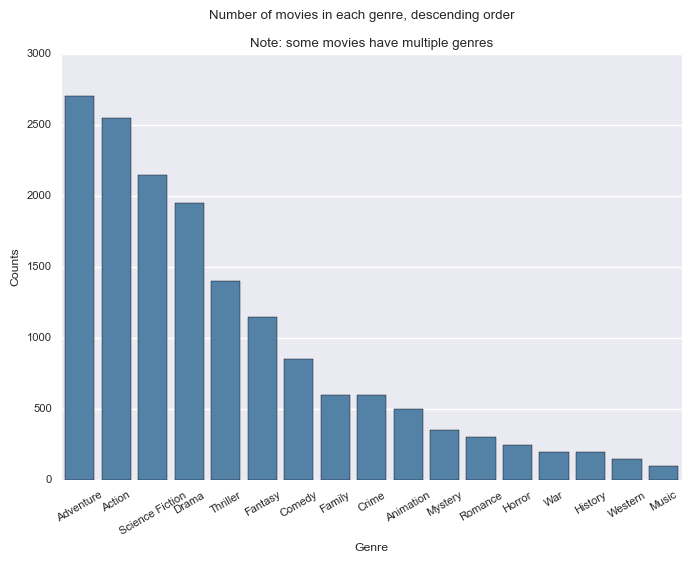

In [4]:
genre_names_encoded = [genre_dict_by_id[int(one_hot_encode_genres.columns[i])] for i in range(len(one_hot_encode_genres.columns))]
genre_counts_df = pd.DataFrame({'genre' :genre_names_encoded, 'counts': np.sum(one_hot_encode_genres.values, 0)})

genre_counts_df_sorted = genre_counts_df.sort_values('counts', ascending = False)

sns.set_context({"figure.figsize": (24, 10)})
sns.set(font_scale=0.8)
plt.plot()
sns.barplot(x = genre_counts_df_sorted['genre'], 
            y = genre_counts_df_sorted['counts'],
           color = 'steelblue')
plt.xticks(rotation=30)
plt.xlabel('Genre')
plt.ylabel('Counts')
plt.suptitle('Number of movies in each genre, descending order')
plt.title('Note: some movies have multiple genres')

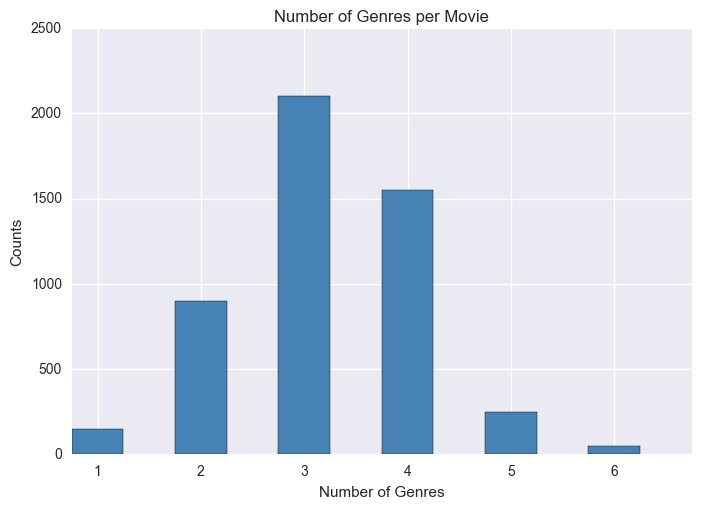

In [8]:
### Get n genres per movie
# Create barplot of n genres per movie
hist_genre_count = collections.Counter(np.sum(one_hot_encode_genres.values, 1) )
A = hist_genre_count.values()
B = map(int, hist_genre_count.keys())

sns.set_context({"figure.figsize": (24, 10)})
sns.set(font_scale=1)

fig, ax = plt.subplots()
bar_width = 0.5
ax.bar(B, A, bar_width, color = 'steelblue')
ax.set_xticks(np.array(B) + bar_width/2)
ax.set_xticklabels(B)
plt.ylabel("Counts")
plt.xlabel("Number of Genres")
plt.title("Number of Genres per Movie")

 Because a single movie can be associated with several different labels, this represents a **multi-label classification problem** where we have to adapt binary classifiers to the multi-label scenario.

## Label Encoding
To encode our labels, we produced code to perform Binary, Pairwise and Label Combination encoding of our multilabel response variable, and will use these in different classifiers ([SOURCE](http://www.cv-foundation.org/openaccess/content_cvpr_2016_workshops/w18/papers/Li_DeepBE_Learning_Deep_CVPR_2016_paper.pdf)). Binary Relevance learns a set of one-vs-all binary classifiers, one for each different label, and requires that the labels be one-hot encoded (create a separate column for each label with 1 if true and 0 if false). 

In [4]:
### ONE HOT ENCODE GENRES
### Fix formatting errors in genres

# Cnverts entries from this form: '[16, 35, 18, 10751, 10402]' -> [16, 35, 18, 10751, 10402] (list of ints)
data_2012_16['genre_ids'] = [map(int, re.sub("[\[ \] ]", "", data_2012_16['genre_ids'][i]).split(',')) for i in range(len(data_2012_16))]

# http://datascience.stackexchange.com/questions/8253/how-to-binary-encode-multi-valued-categorical-variable-from-pandas-dataframe

data_count_genres = data_2012_16['genre_ids'].apply(collections.Counter)
one_hot_encode_genres = pd.DataFrame.from_records(data_count_genres).fillna(value=int(0))
data_2012_16 = data_2012_16.join(one_hot_encode_genres)

print (data_2012_16.head(4))

# Write to CSV: top_100_2016_onehot_genres.csv
# data_2012_16.to_csv('combined_data_2012to2016_onehot_genres.csv')

   Unnamed: 0  Unnamed: 0.1                       poster_path                              title release_date                                           overview  popularity                     original_title                     backdrop_path  vote_count  video  adult  vote_average original_language     id         genre_ids   12   14   16   18   27   28   35   36   37   53   80  878  9648  10402  10749  10751  10752   12   14   16   18   27   28   35   36   37   53   80  878  9648  10402  \
0           0             0  /cezWGskPY5x7GaglTTRN4Fugfb8.jpg                       The Avengers   2012-04-25  When an unexpected enemy emerges and threatens...    9.622596                       The Avengers  /hbn46fQaRmlpBuUrEiFqv0GDL6Y.jpg        9868  False  False           7.4                en  24428     [878, 28, 12]  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0   0.0    0.0    0.0    0.0    0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0   0.0    0.0   
1         

In [5]:
# read the saved one-hot-encoded data
data_encoded = pd.read_csv("combined_data_2012to2016_onehot_genres.csv")
# extract the encoded genres
data_genres = data_encoded[data_encoded.columns[16:33]]

In [6]:
# match genre name to the id
# read genre list
genre_names = pd.read_csv("genre_list.csv")
# conver the dataframe into a dictionary
genre_names = genre_names.set_index("id")
genre_name_dict = genre_names.to_dict()['GenreName']

# replace genre id with genre names
data_genres.columns = map(int, data_genres.columns)
data_genres = data_genres.rename(columns = genre_name_dict)

In [7]:
data_genres.head()

,Adventure,Fantasy,Animation,Drama,Horror,Action,Comedy,History,Western,Thriller,Crime,Science Fiction,Mystery,Music,Romance,Family,War
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Pairwise models train a binary model for each pair of labels in addition to the single labels (so labels would include Romance, Comedy, Romance$\times$Comedy) and is beneficial in reflecting genres that occur together with a single other genre. Label Combination creates a separate column for each combination of label sets (Romance, Comedy, Drama, Romance$\times$Comedy, Romance$\times$Comedy$\times$Drama) and models correlations between a larger number of genres than pairwise encoding. Other methods for encoding include Deep Binary Encoding for Multilabel Classification, which uses deep convolutional neural networks to transform multiple labels into single labels while modeling the dependencies between labels ([SOURCE](http://www.cv-foundation.org/openaccess/content_cvpr_2016_workshops/w18/papers/Li_DeepBE_Learning_Deep_CVPR_2016_paper.pdf)). This is a way in which genres may be grouped together. 

Because some movies did not include genre labels (for example, some movies had zero votes and zero popularity, and very little information), we **excluded these entries from our dataset**. While these movies might not be missing at random from the dataset (and missingness may correlate with other characteristics such as popularity, budget, and rating), we **decided to eliminate these values rather than impute them**, because (1) less than 4% of movies have missing genre labels, so our training set is not significantly reduced and (2) multiple imputation of our response variable may lead to incorrect inferences on the data. 

## Addressing Data Imbalance

From data exploration, we noticed that certain movie genres have fewer movies compared to the others. For example, there are only less than 3% of the movies with label “Western”, whereas there are more than 40% movies with a drama label. The imbalanced distribution of our dataset may be because certain genres tend to be more popular and profitable over the others. To address issues with training models and assessing performance, we will find ways to **reduce the set of genres, oversample the data to produce more training examples of minority labels, adjust classifier weights based on class frequency, and modify the cost function to penalize errors on minority classes**. Because some genres have a small sample size (ex: 3%), we will **eliminate genres with a small sample size**, after examining the counts of genres in our training dataset for a natural drop off in genre frequency. To train our models and reduce overfitting to the majority genres (like Action and Drama), we will upsample (the minority observations) or downsample (the majority observations) so the classifier sees more examples of the uncommon labels and can perform despite the imbalanced training set. In addition, some supervised machine learning methods can use class weights to further address the imbalance issue. Finally, because assessing label accuracy may miss labeling errors in minority classes, we can consider different measures of accuracy that takes into account errors in rare labels (**Cost-sensitive training**). For example, Boutell et al. 2004 ([ref](https://www.rose-hulman.edu/~boutell/publications/boutell04PRmultilabel.pdf)) gives a generalized version of accuracy in multilabel classification where different costs can be specified for different types of errors (ex: false positives and true negatives). 


$$Accuracy(H,D) = \frac{1}{|D|} \sum_{i=1}^{|D|} ( \frac{|Y_i \cap Z_i|}{|Y_i \cup Z_i|}^a$$

Where: D = dataset, Y_i = dataset labels, H = multilabel classification output, Z_i = set of labels predicted by H for example X_i. The parameter a is the “forgiveness rate” that calibrates the severity of different errors. 


## Features to be included in our model

### Features include the movie metadata:

Movie features: 
- Cast:  certain actors and actresses may usually appear in a specific genre type
    - Also look at cast gender (mostly male/mostly female could indicate genre) 
- Director: one director tend to make movies of similar genres
- Released date: according to our EDA in the last report, there is a pattern for different genres released in different months
- Duration: movies of different genres naturally may have different duration, for example animations can be much shorter than documentary
- Ratings: ratings reflected the target audience, which can immediately signalize the genres with much underage suitable contents
- Screen ratio: it will indicate whether the movie is released in IMAX or not, and certain movie genres are more likely to choose the IMAX format
- Popularity: some genres can be more popular than the others
- Vote: some genres can be have more votes than the others

### Text Features and Analysis: 
Our text data includes the reviews and movie titles, as well as information we could scrape off of additional websites such as Wikipedia. One challenge of using text data is text representation, which is mapping high-dimensional text documents into a compact data structure, such as a vector or a dictionary. When applying neural networks to our text data, we will have to find ways to create relevant embeddings of our data. To analyze the text data, we will use the NLTK package in Python to eliminate neutral words (stop words), label parts of speech as well as n-grams (combinations of adjacent words) that might better reflect the meaning of combinations of words.

According to our EDA on the top 500 movies of 2016, the **length of the movie title and reviews** varies by genres, so this may be one simple feature that could be predictive of genre type. Additional features include keywords in movie titles and movie reviews - to extract these keywords, we will attempt a few methods:

- http://www.jait.us/uploadfile/2014/1223/20141223050800532.pdf
- Application of neural networks to NLP: http://u.cs.biu.ac.il/~yogo/nnlp.pdf
- We will examine Latent Dirichlet Allocation to identify words indicative of different movie topics. 

### Image Analysis: 
Poster Analysis on the following features:
- RGB ratio: certain movies may tend to have a poster with cooler tones while the other may tend to have warmer tones
- Illuminance ratio: certain movies may tend to have a poster with darker tones while the other may tend to have brighter tones
- Number of faces in poster: drama movies may have more face in the poster compared to documentary movie (Dlib get_frontal_face_detector()
- male/female ratio in the poster: adventure/war movies may have a higher male/female ratio compared to romance movies

